In [1]:
# simple encoder - decoder example
import numpy as np
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
import scipy.io as io
import scipy.misc
from matplotlib.pyplot import imshow, plot, show

/Users/granty/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [60]:
# load data 
mat_contents = io.loadmat('/Users/granty/Data/CS230_train/keras_ex5.mat')
Xin = mat_contents['X']
Yout = mat_contents['Yout']
num_samples, X_t, num_notes = Xin.shape
Y_t = Yout.shape[1]
print(Yout.shape)
print(Xin.shape)
X_train = Xin.reshape(num_samples,X_t,num_notes)
Y_train = Yout.reshape(num_samples,Y_t,1)

(126, 11025)
(126, 100, 176)


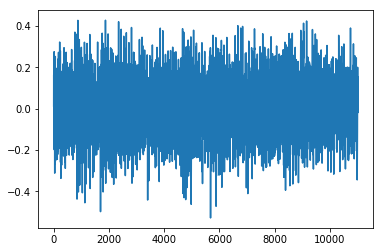

In [63]:
plot(Y_train[100][:].flatten())

In [122]:
def bidi_LSTM(X_t, num_notes, Y_t ):
    # define bidirectional LSTM configuration
    n_neurons_encoder = 100 # refers to size of Memory matrices (can be anything)
    n_neurons_decoder = 10
    intermediate_layer = 500;

    # create LSTM
    model = Sequential()
    # encoder
    model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),input_shape = (X_t,num_notes)))
    model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),input_shape = (X_t,n_neurons_encoder)))
    model.add(Bidirectional(LSTM(n_neurons_encoder)))
    model.add(RepeatVector(intermediate_layer))
    # decoder
    model.add(Bidirectional(LSTM(n_neurons_decoder, return_sequences = True), input_shape=(Y_t/2,n_neurons_decoder)))
    model.add(Bidirectional(LSTM(n_neurons_decoder)))
    model.add(RepeatVector(Y_t))
    model.add(Bidirectional(LSTM(n_neurons_decoder, return_sequences = True), input_shape=(Y_t,n_neurons_decoder)))
    model.add(TimeDistributed(Dense(1)))

    return model

In [123]:
model = bidi_LSTM(X_t,num_notes,Y_t)
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_54 (Bidirectio (None, 100, 200)          221600    
_________________________________________________________________
bidirectional_55 (Bidirectio (None, 100, 200)          240800    
_________________________________________________________________
bidirectional_56 (Bidirectio (None, 200)               240800    
_________________________________________________________________
repeat_vector_20 (RepeatVect (None, 500, 200)          0         
_________________________________________________________________
bidirectional_57 (Bidirectio (None, 500, 20)           16880     
_________________________________________________________________
bidirectional_58 (Bidirectio (None, 20)                2480      
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 11025, 20)         0         
__________

In [118]:
n_batch = 20 # number of training examples 
n_epoch = 3
#print(model.summary())
# train LSTM
model.fit(X_train, Y_train, epochs=n_epoch, batch_size=n_batch)
# evaluate


Epoch 1/3
126/126 [==============================] - 195s 2s/step - loss: 0.0106
Epoch 2/3
126/126 [==============================] - 190s 2s/step - loss: 0.0103
Epoch 3/3
126/126 [==============================] - 189s 2s/step - loss: 0.0102


In [119]:
# evaluate 
result = model.predict(X_train, batch_size=n_batch)
#print(result)

(126, 11025, 1)


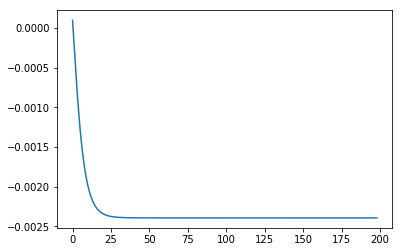

In [121]:
print(result.shape)
plot(result[50][1:200])
#plot(Y_train[100][1:100])

In [41]:
print(np.sum((result.flatten()-Y_train.flatten())**2)/44100)
print(result.flatten()[10:15])

0.0107055197050432
[-0.0141605  -0.01431329 -0.01438704 -0.01441133 -0.01440697]
